## Deterministic Volatility Modeling using GARCH (1,1) Model

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as spop

### Download Data from Yahoo Finance

In [2]:
ticker = '^GSPC'
start = '2015-12-31'
end = '2022-12-31'

prices = yf.download(ticker, start, end)['Close']

[*********************100%%**********************]  1 of 1 completed


In [3]:
prices

Date
2015-12-31    2043.939941
2016-01-04    2012.660034
2016-01-05    2016.709961
2016-01-06    1990.260010
2016-01-07    1943.089966
                 ...     
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
2022-12-30    3839.500000
Name: Close, Length: 1763, dtype: float64

### Data manipulation and Required Field calculation

In [4]:
price_df = pd.DataFrame(prices)

In [5]:
returns = np.array(prices)[1:] / np.array(prices)[:-1] - 1

In [6]:
returns

array([-0.01530373,  0.00201223, -0.0131154 , ..., -0.01202064,
        0.01746133, -0.00254074])

In [7]:
#Starting parameter values - sample mean and variance

mean = np.average(returns)
var = np.std(returns) ** 2

In [8]:
prices.index[1:]

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Date', length=1762, freq=None)

In [9]:
mean, var

(0.00043208984014956095, 0.00014764141735207229)

## Finding Model Parameter using Model Calibration using Maximum Likelihood Estimation

In [10]:
def Garch_Mle(params):
    # Model parameters
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    
    #Calculate long run valatility
    long_run = (omega / (1 - alpha - beta)) ** (1/2)
    
    resid = returns - mu
    realised = abs(resid)
    conditional = np.zeros(len(returns))
    conditional[0] = long_run
    
    for i in range(1, len(returns)):
        conditional[i] = (omega + alpha*resid[i-1]**2 + beta*conditional[i-1]**2)**(1/2)
        
    #calculate Log-Likelihood
    likelihood = 1/((2*np.pi)**(1/2)*conditional)*np.exp(-realised**2/(2*conditional**2))
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood

In [11]:
#Maximizing Log-Likelihood
res = spop.minimize(Garch_Mle, [mean, var, 0, 0], method = 'Nelder-Mead')

<ipython-input-10-859f585fe45a>:9: RuntimeWarning: invalid value encountered in scalar power
  long_run = (omega / (1 - alpha - beta)) ** (1/2)


### Retriving Model parameters and calculating required optimal parameters

In [12]:
# Retrive Optimal parameters

params = res.x
params

array([8.72363185e-04, 3.63218446e-06, 2.21922218e-01, 7.63675864e-01])

In [13]:
mu = res.x[0]
omega = res.x[1]
alpha = res.x[2]
beta = res.x[3]

mu, omega, alpha, beta

(0.0008723631851520312,
 3.6321844616669995e-06,
 0.22192221767432957,
 0.7636758635900618)

In [14]:
log_likelihood = -float(res.fun)

In [15]:
log_likelihood

5827.119080903557

In [16]:
long_run = (omega / (1-alpha-beta))**(1/2)
resid = returns - mu
realize = abs(resid)
conditional = np.zeros(len(returns))
conditional[0] = long_run

In [17]:
for i in range(1, len(returns)):
    conditional[i] = (omega + alpha*resid[i-1]**2 + beta*conditional[i-1]**2)**(1/2)

In [18]:
conditional

array([0.01588085, 0.01594684, 0.01407568, ..., 0.01094362, 0.01148835,
       0.0128645 ])

In [19]:
len(prices.index[1:]), len(returns)

(1762, 1762)

## Ploting Actual VS Modelled output

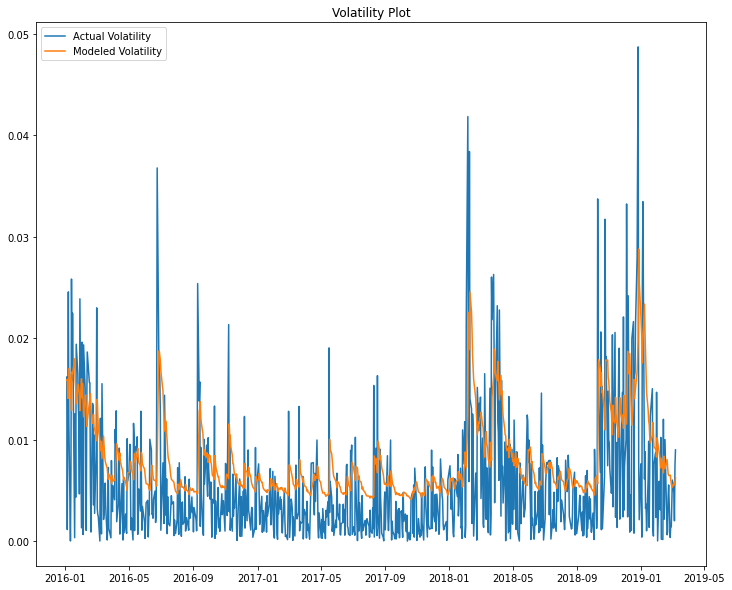

In [20]:
plt.figure(figsize = (12,10))
plt.rc('xtick', labelsize=10)
plt.plot(np.array(prices.index[1:800]), realize[:799], label = 'Actual Volatility')
plt.plot(np.array(prices.index[1:800]), conditional[:799], label = 'Modeled Volatility')
plt.title('Volatility Plot')
plt.legend()
plt.show()